In [1]:
import os
import pandas as pd
import time
import random
import numpy as np

import itertools
import networkx as nx

import matplotlib.pyplot as plt


In [2]:
# import pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout

import pygraphviz

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

---
#### Functions

In [5]:
# check if a directory exists, if not creat it 
def check_directory(directory):
    if not os.path.isdir(directory):
        print("directory '{}' doesn't exist, creat it now...".format(directory))
        os.makedirs(directory)
    else:
        print("directory '{}' found.".format(directory))


In [6]:
# graph visualization
def graph_viz(graph, pos=None, fig_size=(8, 8)):
    fig = plt.figure(figsize=fig_size,facecolor='white')
    # np.random.seed(1000)

    if pos is None:
        pos = graphviz_layout(graph)
    # pos = nx.spring_layout(graph)

    # d = dict(graph.out_degree())

    nx.draw(graph, 
            pos=pos,
            alpha=0.6,
            node_color='#386cb0',
            # node_size=[v * 50 if v>0 else 50 for (k,v) in d.items()]
            # edge_color='#999999'
           )

    plt.axis('on')
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()

In [7]:
# All the ego networks we defined are directed

# computing social bridges (multiple threshold mode)
def social_bridges(G, ego, thresholds, draw=False, pos=None):
    """
    G: ego network;
    ego: ego node;
    thresholds: multiple thresholds for Jaccard Similarity, e.g., [0.1, 0.2, 0.3]
    """
    # follower graph
    ns1 = set(G.predecessors(ego))
    g1 = G.subgraph(ns1).copy()
    # edges between ns1 (followers) and ns2 (followees of followers)
    edges = []
    for u in ns1:
        lst = G.successors(u)
        # lst = set(lst) - set(ns1) - {ego}
        lst = set(lst) - set(ns1)
        edges += [(u, i) for i in lst]
    # bipartite graph
    # you may use bipartite module in Networkx instead, but it costs much more time and is not scalable for large networks
    g12 = nx.Graph()
    g12.add_edges_from(edges)
    ns2 = set(g12)-set(ns1)
    # common followees between ns1 nodes
    bridges = []
    for u in ns2:
        ns = list(g12.neighbors(u))
        ns.sort()
        lst=list(itertools.combinations(ns, 2))
        bridges += lst
    if len(bridges) == 0:
        # if no bridged connections added
        d = {}
        # d = defaultdict(dict)
        n1 = nx.number_weakly_connected_components(g1)
        for k in thresholds:
            d[k] = n1
        return d
    df = pd.Series(bridges).value_counts().reset_index()
    d0 = G.out_degree(ns1)
    df['frac'] = df.apply(lambda x: float(x[0])/(d0[x['index'][0]]+d0[x['index'][1]]-x[0]), axis=1)
    # 
    d = {}
    # d = defaultdict(dict)
    thresholds = sorted(thresholds, reverse=True)
    for k in thresholds:
        edges_bridged = df[df['frac']>k]['index'].tolist()
        edges_bridged_reversed = [(e[1], e[0]) for e in edges_bridged]
        # add bridged connections
        g1.add_edges_from(edges_bridged)
        g1.add_edges_from(edges_bridged_reversed)
        # bridged (k-clip) diversity measures
        n1 = nx.number_weakly_connected_components(g1)
        d[k] = n1
        if draw:
            graph_viz(g1, pos=pos,fig_size=(4,4))
    return d



### Examples

---
#### example 1

In [8]:

file_path = 'data/sample_graph_[indegree=9, uid=85142].csv'

In [9]:
ego = int(file_path.rsplit('=')[-1].rsplit(']')[0])

edge_df = pd.read_csv(file_path, sep=' ')

edge_df = pd.read_csv(file_path, header=None, sep=' ')
edge_df.rename(columns={0:'source', 1:'target'}, inplace=True)

In [10]:
graph0 = nx.from_pandas_edgelist(edge_df, 'source', 'target', create_using=nx.DiGraph())
print(nx.info(graph0))

Name: 
Type: DiGraph
Number of nodes: 359
Number of edges: 437
Average in degree:   1.2173
Average out degree:   1.2173


In [11]:
ns1 = set(graph0.predecessors(ego))

lst = [list(graph0.successors(i)) for i in ns1]
ns2 = set(list(itertools.chain(*lst)))
ns2 = ns2 - set(ns1) -{ego}

In [12]:
def edge_map(x):
    if ego in x:
        return 0
    elif len(set(x).intersection(ns1))==2:
        return 1
    else:
        return 2

In [13]:
edge_df['edges'] = list(zip(edge_df.source, edge_df.target))

edge_df['edge_type'] = edge_df['edges'].map(edge_map)

edge_df.head()

,source,target,edges,edge_type
0,5803095,85142,"(5803095, 85142)",0
1,5803095,651161,"(5803095, 651161)",2
2,5803095,677597,"(5803095, 677597)",2
3,5803095,1094709,"(5803095, 1094709)",2
4,5803095,1109557,"(5803095, 1109557)",2


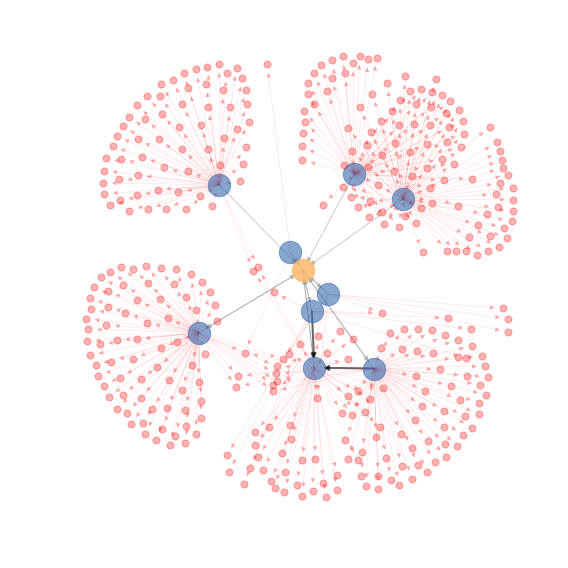

In [14]:

fig_size = (8, 8)

# np.random.seed(100)

fig = plt.figure(figsize=fig_size,facecolor='white')

graph = graph0.copy()


ns1 = set(graph0.predecessors(ego))

lst = [list(graph0.successors(i)) for i in ns1]
ns2 = set(list(itertools.chain(*lst)))
ns2 = ns2 - set(ns1) -{ego}



d = dict(graph.out_degree())


# pos = nx.circular_layout(graph)
# pos = nx.spectral_layout(graph)
# pos = nx.spring_layout(graph)

pos = graphviz_layout(graph)

# nodes
# nodes = list(graph)
# nodes.remove(ego)

base_size = 100
# node_sizes = [d[i] *base_size if d[i]>0 else base_size for i in nodes]

node_sizes = [d[i] *base_size if d[i]>0 else base_size for i in ns1]

nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=ns1,
                       # node_color='r',
                       # node_color='#ef3b2c',
                       # node_color='#386cb0',
                       node_color='#386cb0',
                       # node_size=500,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()],
#                        node_size = node_sizes,
                       node_size = 500,
                       alpha=0.6)


nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=[ego],
                       node_color='#fdb462',
                       node_size=500,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()]
                       alpha=0.8)


nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=ns2,
                       node_color='r',
                       node_size=50,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()]
                       alpha=0.3)



# edges
ego_edges = edge_df[edge_df['edge_type']==0]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=ego_edges,
                       width=1, 
                       alpha=0.5, 
                       edge_color='#999999')


edges = edge_df[edge_df['edge_type']==1]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=edges,
                       width=2, 
                       alpha=0.6, 
                       edge_color='black')


edges = edge_df[edge_df['edge_type']==2]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=edges,
#                        style='dashdot',
                       width=.25, 
                       alpha=0.3, 
                       edge_color='r')


labels = {}
for i in ns1:
    labels[i] = i
    
# nx.draw_networkx_labels(graph, pos, labels, font_size=10)


plt.axis('off')

plt.tight_layout()

# folder = 'results/social_bridges_{}'.format(ego)
# check_directory(folder)
# plt.savefig(os.path.join(folder, 'social_bridges_{}.pdf'.format(ego)), bbox_inches='tight', pad_inches=0)


# plt.show()

---
diversity measure: via social bridges

In [15]:
G=graph.copy()

thresholds = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]

# return bridged (k-clip) diversity measure for each Jaccard threshold
social_bridges(G, ego, thresholds)

{0.5: 7, 0.3: 6, 0.2: 6, 0.15: 6, 0.1: 5, 0.05: 4}

{0.5: 7, 0.3: 6, 0.2: 6, 0.15: 6, 0.1: 5, 0.05: 4}

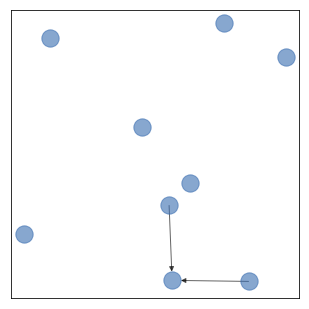

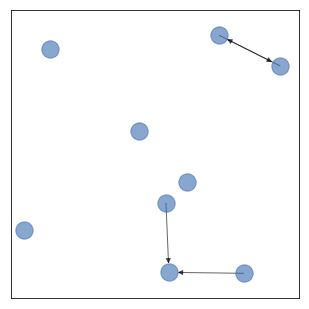

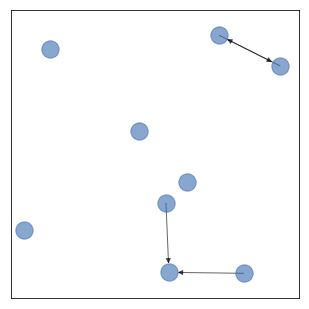

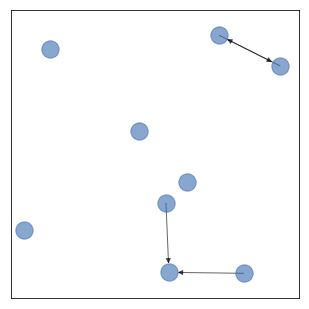

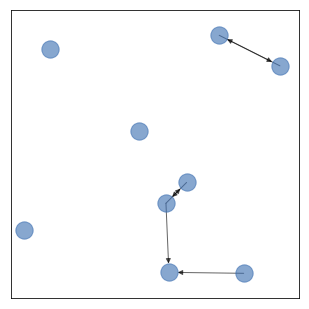

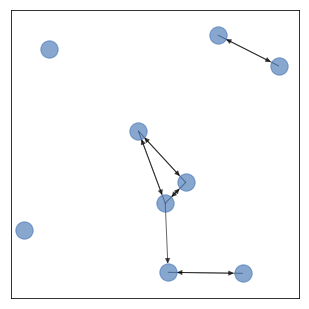

In [16]:
G=graph.copy()

thresholds = [0.5, 0.3, 0.2, 0.15, 0.1, 0.05]

# return bridged (k-clip) diversity measure for each Jaccard threshold

# follower graph visualization enabled 
social_bridges(G, ego, thresholds, draw=True, pos=pos)

---
#### example 2

In [17]:
file_path = 'data/sample_graph_[indegree=5, uid=85176].csv'


In [18]:
ego = int(file_path.rsplit('=')[-1].rsplit(']')[0])

edge_df = pd.read_csv(file_path, sep=' ')

edge_df = pd.read_csv(file_path, header=None, sep=' ')
edge_df.rename(columns={0:'source', 1:'target'}, inplace=True)

In [19]:
graph0 = nx.from_pandas_edgelist(edge_df, 'source', 'target', create_using=nx.DiGraph())
print(nx.info(graph0))

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 105
Average in degree:   1.0500
Average out degree:   1.0500


In [20]:
ns1 = set(graph0.predecessors(ego))

lst = [list(graph0.successors(i)) for i in ns1]
ns2 = set(list(itertools.chain(*lst)))
ns2 = ns2 - set(ns1) -{ego}

In [21]:
def edge_map(x):
    if ego in x:
        return 0
    elif len(set(x).intersection(ns1))==2:
        return 1
    else:
        return 2

In [22]:
edge_df['edges'] = list(zip(edge_df.source, edge_df.target))

# edge_df['ego_included'] = edge_df.apply(lambda x: 1 if ego in [x['source'], x['target']] else 0, axis=1)
edge_df['edge_type'] = edge_df['edges'].map(edge_map)

edge_df.head()

,source,target,edges,edge_type
0,85176,6412996,"(85176, 6412996)",0
1,85176,7405249,"(85176, 7405249)",0
2,7912329,85176,"(7912329, 85176)",0
3,7912329,13996,"(7912329, 13996)",2
4,7912329,2134139,"(7912329, 2134139)",2


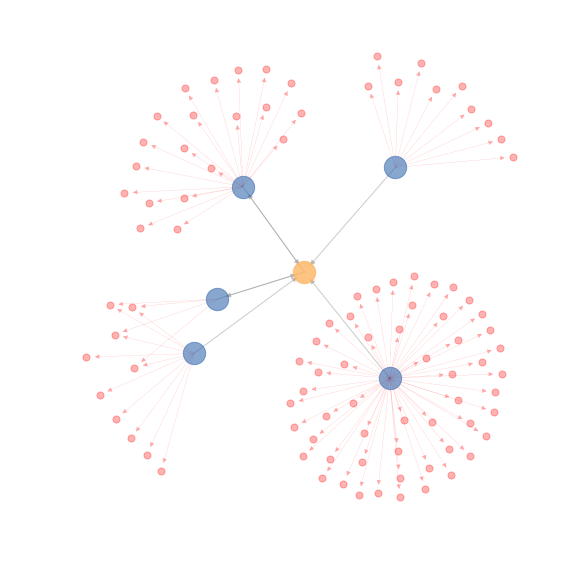

In [23]:

fig_size = (8, 8)

# np.random.seed(100)

fig = plt.figure(figsize=fig_size,facecolor='white')

graph = graph0.copy()


ns1 = set(graph0.predecessors(ego))

lst = [list(graph0.successors(i)) for i in ns1]
ns2 = set(list(itertools.chain(*lst)))
ns2 = ns2 - set(ns1) -{ego}



d = dict(graph.out_degree())


# pos = nx.circular_layout(graph)
# pos = nx.spectral_layout(graph)
# pos = nx.spring_layout(graph)

pos = graphviz_layout(graph)

# nodes
# nodes = list(graph)
# nodes.remove(ego)

base_size = 100
# node_sizes = [d[i] *base_size if d[i]>0 else base_size for i in nodes]

node_sizes = [d[i] *base_size if d[i]>0 else base_size for i in ns1]

nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=ns1,
                       # node_color='r',
                       # node_color='#ef3b2c',
                       # node_color='#386cb0',
                       node_color='#386cb0',
                       # node_size=500,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()],
#                        node_size = node_sizes,
                       node_size = 500,
                       alpha=0.6)


nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=[ego],
                       node_color='#fdb462',
                       node_size=500,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()]
                       alpha=0.8)


nx.draw_networkx_nodes(graph, 
                       pos,
                       nodelist=ns2,
                       node_color='r',
                       node_size=50,
                       # node_size=[v * 100 if k!=ego else 300 for (k,v) in d.items()]
                       alpha=0.3)



# edges
ego_edges = edge_df[edge_df['edge_type']==0]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=ego_edges,
                       width=1, 
                       alpha=0.5, 
                       edge_color='#999999')


edges = edge_df[edge_df['edge_type']==1]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=edges,
                       width=2, 
                       alpha=0.6, 
                       edge_color='black')


edges = edge_df[edge_df['edge_type']==2]['edges'].tolist()
nx.draw_networkx_edges(graph, 
                       pos,
                       edgelist=edges,
#                        style='dashdot',
                       width=.25, 
                       alpha=0.3, 
                       edge_color='r')


labels = {}
for i in ns1:
    labels[i] = i
    
# nx.draw_networkx_labels(graph, pos, labels, font_size=10)


plt.axis('off')

plt.tight_layout()

# folder = 'results/social_bridges_{}'.format(ego)
# check_directory(folder)
# plt.savefig(os.path.join(folder, 'social_bridges_{}.pdf'.format(ego)), bbox_inches='tight', pad_inches=0)


# plt.show()

---
diversity measure: via social bridges

In [24]:
G=graph.copy()

thresholds = [0.5, 0.3, 0.2, 0.15, 0.1, 0.05]
social_bridges(G,ego,thresholds)

{0.5: 5, 0.3: 4, 0.2: 4, 0.15: 4, 0.1: 4, 0.05: 3}

{0.5: 5, 0.3: 4, 0.2: 4, 0.15: 4, 0.1: 4, 0.05: 3}

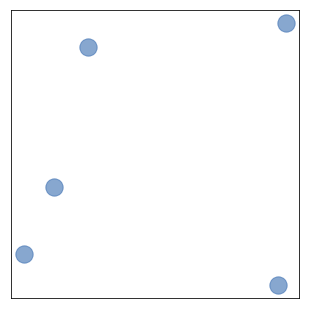

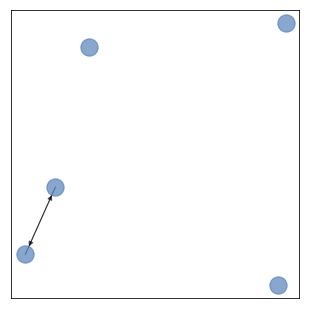

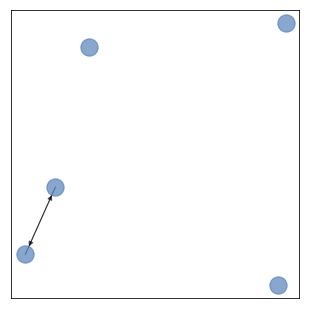

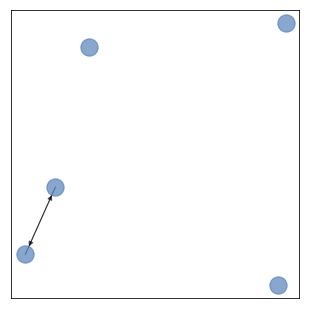

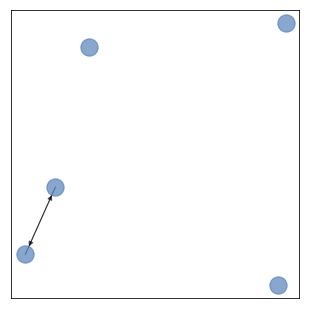

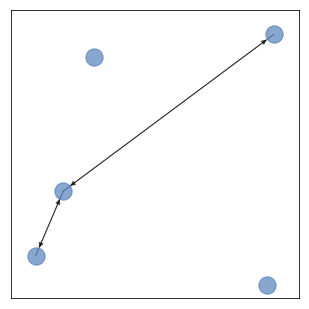

In [25]:
G=graph.copy()

thresholds = [0.5, 0.3, 0.2, 0.15, 0.1, 0.05]

# return bridged (k-clip) diversity measure for each Jaccard threshold

# follower graph visualization enabled 
social_bridges(G, ego, thresholds, draw=True, pos=pos)